##### uncomment the cell below to install the libraries necessary for this project

In [1]:
# pip install -r requirements.txt

##### to find out the total run time of the notebook (after installing requirements), run all the cells below at once.

In [2]:
# t1, below, serves as the start time of the notebook. you'll need it to calculate the total runtime of the notebook (i.e. endtime - starttime) 

import time
t1 = time.time()

# importing other libraries necessary for the project

from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
import re
import pandas as pd
from datetime import datetime

C:\Users\adeda\AppData\Local\Temp\ipykernel_26296\1866043064.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
base_url = 'https://fbref.com'
html = requests.get(f'{base_url}/en/comps/9/Premier-League-Stats') # getting the html file of the url's webpage
bs = BeautifulSoup(html.text, 'html.parser') # parsing the returned file as html

In [4]:
"""
The find_all looks to capture all 'a' tags with the 'href' value matching the provided regex.
The value must have the following properties to match the regex:
- starts with '/en/squads/'
- followed by a string containing numbers and/or lowercase alphabets (no min nor max count)
- followed by '/' + a string containing a string of uppercase and/or lowercase alphabets (no min nor max count)
- followed by '-Stats'

[:20] stores only the first 20 strings (all we need)

"""
team_a_tag = bs.find_all('a', {'href':re.compile('\/en\/squads\/[a-z0-9]*\/[A-Za-z\-]*\-Stats')})[:20]

# concatenate the base url with the path of each team
team_urls = [f"{base_url}{a_tag['href']}" for a_tag in team_a_tag]
#first five items in the list
team_urls[:5]

['https://fbref.com/en/squads/822bd0ba/Liverpool-Stats',
 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats',
 'https://fbref.com/en/squads/18bb7c10/Arsenal-Stats',
 'https://fbref.com/en/squads/8602292d/Aston-Villa-Stats',
 'https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats']

In [5]:
"""
The following function returns a list of desired data stored in a row of a 'Shooting' table (see sample: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats#stats_shooting_9)

The table stores data for goalkeepers, as well as outfield players. Most of the data to be extracted from the table are irrelevant to goalkeepers, that's why I filtered out players with position == 'GK'.

A player's name and age will be used as the primary key to uniquely identify each player's stats. It is assumed that a player's name and age (in years and days) are enough to uniquely identify each player in the league.

The function will be called for every row (or player) in each team's table. It takes the 'club_name' parameter which will be the same for every player in the same table.
"""
def get_player_shoot_stat(row, club_name):
    position = row.find('td', {'data-stat':'position'}).get_text()
    if position != 'GK':
        name = row.find('th').get_text()
        age = row.find('td', {'data-stat':'age'}).get_text()
        position = row.find('td', {'data-stat':'position'}).get_text()
        minutes_90s = row.find('td', {'data-stat':'minutes_90s'}).get_text()
        goals = row.find('td', {'data-stat':'goals'}).get_text()
        pens_made = row.find('td', {'data-stat':'pens_made'}).get_text()
        xg = row.find('td', {'data-stat':'xg'}).get_text()
        npxg = row.find('td', {'data-stat':'npxg'}).get_text()
        return [age, name, position, club_name, minutes_90s, goals, pens_made, xg, npxg]

"""
The following function returns a list containing the name, age, assist and xg_assist stored in a row of a 'Passing' table (see sample: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats#stats_passing_9).

The table stores data for goalkeepers, as well as outfield players. Most of the data to be extracted from the table are irrelevant to goalkeepers, that's why I filtered out players with position == 'GK'.

A player's name and age will be used as the primary key to uniquely identify each player's stats. It is assumed that a player's name and age (in years and days) are enough to uniquely identify each player in the league.
"""

def get_player_pass_stat(row):
    position = row.find('td', {'data-stat':'position'}).get_text()
    if position != 'GK':
        name = row.find('th').get_text()
        age = row.find('td', {'data-stat':'age'}).get_text()
        assists = row.find('td', {'data-stat':'assists'}).get_text()
        xg_assist = row.find('td', {'data-stat':'xg_assist'}).get_text()
        return [age, name, assists, xg_assist]

"""
The following function returns a list containing the name, age and shot creating action (sca) stored in a row of a 'Goal and Shot Creation' table (see sample: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats#stats_gca_9)

The table stores data for goalkeepers, as well as outfield players. The sca stat irrelevant to goalkeepers, that's why I filtered out players with position == 'GK'.

A player's name and age will be used as the primary key to uniquely identify each player's stats. It is assumed that a player's name and age (in years and days) are enough to uniquely identify each player in the league.
"""

def get_player_sca_stat(row):
    position = row.find('td', {'data-stat':'position'}).get_text()
    if position != 'GK':
        name = row.find('th').get_text()
        age = row.find('td', {'data-stat':'age'}).get_text()
        sca = row.find('td', {'data-stat':'sca'}).get_text()
        return [age, name, sca]

"""
The following function returns a list of desired data stored in a row of a 'Advanced Goalkeeping' table (see sample: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats#stats_keeper_adv_9)

The table stores data for goalkeepers(GK) only.

The GK's name and age will be used as the primary key to uniquely identify each gk's stats. It is assumed that a gk's name and age (in years and days) are enough to uniquely identify each gk in the league.

The function will be called for every row (or goalkeeper) in each team's table. It takes the 'club_name' parameter which will be the same for every gk in the same table.
"""

def get_adv_keeper_stats(row, club_name):
    name = row.find('th').get_text()
    age = row.find('td', {'data-stat':'age'}).get_text()
    position = row.find('td', {'data-stat':'position'}).get_text()
    minutes_90s = row.find('td', {'data-stat':'minutes_90s'}).get_text()
    goals_against = row.find('td', {'data-stat':'gk_goals_against'}).get_text()
    pens_allowed = row.find('td', {'data-stat':'gk_pens_allowed'}).get_text()
    own_goals_against = row.find('td', {'data-stat':'gk_own_goals_against'}).get_text()
    psnpxg_per_shot_on_target_against = row.find('td', {'data-stat':'gk_psnpxg_per_shot_on_target_against'}).get_text()
    psxg_net = row.find('td', {'data-stat':'gk_psxg_net'}).get_text()
    psxg = row.find('td', {'data-stat':'gk_psxg'}).get_text()
    return [age, name, position, club_name, minutes_90s, goals_against, pens_allowed, own_goals_against, psnpxg_per_shot_on_target_against, psxg_net, psxg]


"""
The following function returns a list of desired data stored in a row of a 'Goalkeeping' table (see sample: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats#stats_keeper_adv_9)

The table stores data for goalkeepers(GK) only.

The GK's name and age will be used as the primary key to uniquely identify each gk's stats. It is assumed that a gk's name and age (in years and days) are enough to uniquely identify each gk in the league.
"""

def get_cs_stat(row):
    name = row.find('th').get_text()
    age = row.find('td', {'data-stat':'age'}).get_text()
    clean_sheets = row.find('td', {'data-stat':'gk_clean_sheets'}).get_text()
    return [age, name, clean_sheets]

In [6]:
"""
'outfield_players', 'gk_s' and 'team_logos' are dictionaries. I initialized them as 'defaultdict' objects instead of the more common 'dict' to avoid getting errors when accessing non-existent keys in the dictionary.

the keys of 'outfield_players' and 'gk_s' are tuples with the format '(age, name)' and their values are lists the player's name at index 0.

'team_logos' has the club name as the key and url of the team logo as values.

"""
outfield_players = defaultdict(list) 
gk_s = defaultdict(list)
team_logos = defaultdict(str)

# i request the file for each team's webpage and parse it as html
for url in team_urls:
    html = requests.get(url)
    bs = BeautifulSoup(html.text, 'html.parser')

    """
I get each team's full name from the text stored in the 'div' tag with the 'data-template' attribute and 'Partials/Teams/Summary' value. It wasn't extracted from the starting web page because not all the names were written in full.

The text is saved in the format "2023-2024 'team name' Stats (Premier League)" so I split the string, selected the string between the 0th index and the second-to-last index and joined them with a space between them.
    """
    club_name = ' '.join(bs.find('div', {'data-template': 'Partials/Teams/Summary'}).find('span').get_text().split()[1:-1])

    # I extract all the rows stored in each table of interest and store them separately for later referencing.

    shoot_stat_rows = bs.find('table', {'id':'stats_shooting_9'}).find('tbody').find_all('tr')
    
    gca_stat_rows = bs.find('table', {'id':'stats_gca_9'}).find('tbody').find_all('tr')
    
    pass_stat_rows = bs.find('table', {'id':'stats_passing_9'}).find('tbody').find_all('tr')

    adv_keeper_stat_rows = bs.find('table', {'id':'stats_keeper_adv_9'}).find('tbody').find_all('tr')

    keeper_stat_rows = bs.find('table', {'id':'stats_keeper_9'}).find('tbody').find_all('tr')


    # I map the team to the URL of its logo.
    team_logos[club_name] = bs.find('img', {'class': 'teamlogo'})['src']


    # For each row/player, I extract the relevant data and store them in the 'outfield_players' dictionary.
    for row in shoot_stat_rows:
        player_stats = get_player_shoot_stat(row, club_name)
        if player_stats:
            outfield_players[player_stats[0], player_stats[1]] = player_stats[1:]

    # For each row/player, I extract the 'assists' and 'xg_assist' and append them to the player's list of information in the 'outfield_players' dictionary.      
    for row in pass_stat_rows:
        player_stats = get_player_pass_stat(row)
        if player_stats:
            outfield_players[player_stats[0], player_stats[1]].extend(player_stats[2:])

    # For each row/player, I extract the 'sca' and append it to the player's list of information in the 'outfield_players' dictionary.
    for row in gca_stat_rows:
        player_stats = get_player_sca_stat(row)
        if player_stats:
            outfield_players[player_stats[0], player_stats[1]].append(player_stats[2])

    # For each row/gk, I extract the relevant data and store them in the 'gk_s' dictionary.    
    for row in adv_keeper_stat_rows:
        keeper_stats = get_adv_keeper_stats(row, club_name)
        gk_s[keeper_stats[0], keeper_stats[1]] = keeper_stats[1:]

    # For each row/gk, I extract the 'clean_sheets' stat and append it to the gk's list of information in the 'gk_s' dictionary.        
    for row in keeper_stat_rows:
        keeper_stat = get_cs_stat(row)
        gk_s[keeper_stat[0], keeper_stat[1]].append(keeper_stat[2])
    """
FBREF limits users to 20 requests per minute. Exceeding this limit will result in placing a user's session in jail for one hour. To avoid this, I have added the following 4-second delay (max. of about 15 requests per minute). 

Link to FBREF's web scraping policy: https://www.sports-reference.com/bot-traffic.html
    """
    time.sleep(4)

In [8]:
list(outfield_players.items())[:2]

[(('31-228', 'Mohamed Salah'),
  ['Mohamed Salah',
   'FW',
   'Liverpool',
   '19.3',
   '14',
   '4',
   '14.3',
   '9.4',
   '8',
   '8.5',
   '88']),
 (('32-205', 'Virgil van Dijk'),
  ['Virgil van Dijk',
   'DF',
   'Liverpool',
   '18.3',
   '1',
   '0',
   '1.6',
   '1.6',
   '2',
   '1.1',
   '30'])]

In [9]:
# i extract each player's data stored as a list in 'outfield_players'.
outfield_players_data = [value for value in outfield_players.values()]

# i create a pandas data frame with each nested list in 'outfield_players_data' passed as a row in the dataframe.
outfield_df = pd.DataFrame(outfield_players_data, columns = ['name', 'position', 'club_name', 'minutes_90s', 'goals', 'pens_made', 'xg', 'npxg', 'assists', 'xg_assist', 'sca'])

In [10]:
# i identify which columns should have a data type of float or integer
float_dt = ['minutes_90s', 'xg', 'npxg', 'xg_assist']
int_dt = ['goals', 'pens_made', 'sca']

# i substitute empty column string values for NaN, then substitute them for 0 and finally cast the column values to float (or integer, as required.)
outfield_df[float_dt] = outfield_df[float_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).astype(float))
outfield_df[int_dt] = outfield_df[int_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).astype(int))

In [11]:
outfield_df.head()

,name,position,club_name,minutes_90s,goals,pens_made,xg,npxg,assists,xg_assist,sca
0,Mohamed Salah,FW,Liverpool,19.3,14,4,14.3,9.4,8,8.5,88
1,Virgil van Dijk,DF,Liverpool,18.3,1,0,1.6,1.6,2,1.1,30
2,Dominik Szoboszlai,MF,Liverpool,17.7,2,0,1.8,1.8,2,4.2,73
3,Trent Alexander-Arnold,DF,Liverpool,16.6,2,0,1.8,1.5,3,5.1,91
4,Luis Díaz,FW,Liverpool,13.5,3,0,3.9,3.9,1,1.6,64


In [12]:
# i extract each gk's data stored as a list in 'gk_s'
gk_data = [value for value in gk_s.values()]

# i create a pandas data frame with each nested list in 'gk_data' passed as a row in the data frame.
gk_df = pd.DataFrame(gk_data, columns = ['name', 'position', 'club_name', 'minutes_90s', 'goals_against', 'pens_allowed', 'own_goals_against', 'psnpxg_per_shot_on_target_against', 'psxg_net', 'psxg', 'clean_sheets'])

In [13]:
# i identify which columns should have a data type of float or integer
float_dt = ['minutes_90s', 'psnpxg_per_shot_on_target_against', 'psxg_net', 'psxg', ]
int_dt = ['goals_against', 'pens_allowed', 'own_goals_against', 'clean_sheets']

# i substitute empty column string values for NaN, then substitute them for 0 and finally cast the column values to float (or integer, as required.)
gk_df[float_dt] = gk_df[float_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0.0).astype(float))
gk_df[int_dt] = gk_df[int_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).astype(int))

In [14]:
gk_df.head()

,name,position,club_name,minutes_90s,goals_against,pens_allowed,own_goals_against,psnpxg_per_shot_on_target_against,psxg_net,psxg,clean_sheets
0,Alisson,GK,Liverpool,19.0,15,1,1,0.25,3.0,17.0,7
1,Caoimhín Kelleher,GK,Liverpool,2.0,3,0,0,0.37,-0.8,2.2,1
2,Ederson,GK,Manchester City,18.1,20,2,1,0.30,-2.3,16.7,5
3,Stefan Ortega,GK,Manchester City,1.9,3,0,0,0.37,0.0,3.0,0
4,David Raya,GK,Arsenal,16.0,16,1,0,0.28,-2.4,13.6,6


In [15]:
# i save the data frames in CSV format with a suffix of the current date since the dataset changes on a matchday to matchday basis

outfield_df.to_csv(f"outfield_players_data {datetime.now().date().strftime('%d-%m-%Y')}.csv", index=False)

gk_df.to_csv(f"gk_data {datetime.now().date().strftime('%d-%m-%Y')}.csv", index=False)

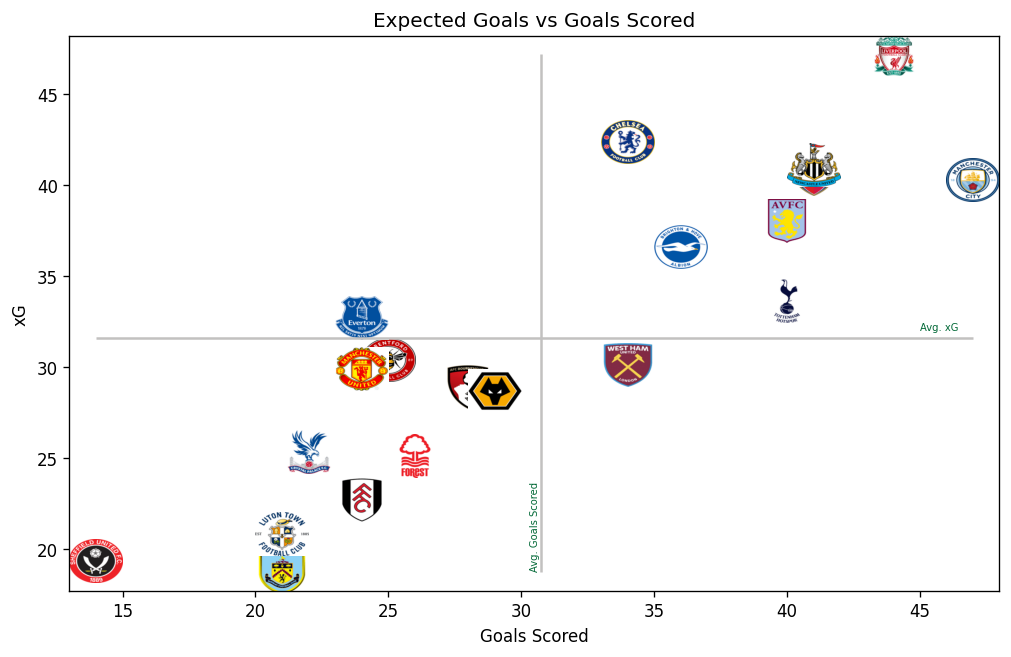

In [16]:
"""
with the following code, i produce a scatter plot that displays a teams' goals scored on the x-axis and expected goals (xg) scored on the y-axis.

The centre of each team’s logo represents the location of their data point. 

From the plot (29-01-2024) we can gather insights like, Chelsea has scored significantly fewer goals than they were expected to, Manchester City has scored at least five more goals than they were expected to, etc.

There is usually a delay when running this cell (takes about 20s to run to completion) partly because the logos are loaded directly from Sports Reference’s (owner of FBREF) servers at runtime. This is inefficient and a user can optimize this by downloading each team’s logo to their local machine and pointing their code (for plotting the diagram) to the downloaded logos. 

The author did not do this because he wanted to move on to other things.
"""
# the data frame that stores the information for each team. '.reset_index()' ensures the club_name is a column, not an index after grouping the data.
df = outfield_df.groupby('club_name')[['goals','xg']].sum().reset_index()

# setting the canvas size
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

# storing the mininmum, maximum and mean values of 'goals' and 'xg' for later referencing.
min_goals = min(df['goals'])
max_goals = max(df['goals'])
min_xg = min(df['xg'])
max_xg = max(df['xg'])
mean_goals = df['goals'].mean()
mean_xg = df['xg'].mean()

# calibrating the minimum and maximum tick values of the axes to be one unit below the minimum plotted value and one unit above the maximum plotted value respectively
ax.set_xlim(min_goals - 1, max_goals + 1)
ax.set_ylim(min_xg - 1, max_xg + 1)

# givng the axes and plot labels
ax.set_title('Expected Goals vs Goals Scored')
ax.set_xlabel('Goals Scored')
ax.set_ylabel('xG')

# plotting each data point and relating the data point to the team's logo
for i in range(len(df)):
    team = df.loc[i, 'club_name']
    x = df.loc[i, 'goals']
    y = df.loc[i, 'xg']

    # loading the team's logo
    response = requests.get(team_logos[team])
    img = Image.open(BytesIO(response.content))

    # placing the image on the plot and setting its size with the 'extent' paramenter
    ax.imshow(img, aspect='auto', extent=(x-1, x+1, y-1.2, y+1.2))

# drawing a line to indicate the mean_xg. the line stretches from the min_goals value to the max_goals value 
plt.hlines(mean_xg, min_goals, max_goals, color='#c2c1c0')

# drawing a line to indicate the mean_goals. the line stretches from the min_xg value to the max_xg value 
plt.vlines(mean_goals, min_xg, max_xg, color='#c2c1c0')

# labelling the average xg line. the coordinates of the text are set relative to the mean_xg value and the max_goals value to account for changes in the average line if the notebook is run after a new matchday.
ax.text(max_goals -2, mean_xg+0.4,'Avg. xG', size=6, color='#026937')

# labelling the average goals scored line. the coordinates of the text are set relative to the mean_goals value and the min_xg value to account for changes in the average line if the notebook is run after a new matchday.
ax.text(mean_goals-0.4, min_xg+0.2,'Avg. Goals Scored', size=6, color='#026937',rotation=90)

# save figure with a suffix of the current date to indicate when the figure was generated
plt.savefig(f"xG vs Goals Chart {datetime.now().date().strftime('%d-%m-%Y')}.png", dpi=1200, bbox_inches = "tight")

##### Code for scatter plot adapted from [FCPython](https://fcpython.com/visualisation/creating-scatter-plots-with-club-logos-in-python).

In [17]:
print(f'The whole notebook took {(time.time()-t1)/60} minutes to run on my laptop!')

The whole notebook took 2.231483511130015 minutes to run on my laptop!
